# Principal Component Analysis and k-means Clustering

In this analysis, Principal Component Analysis (PCA) is used together with k-means clustering to group developing contries based on economic characteristics. In a first step, PCA is used to reduce the dimensionality of the data. A k-means algorithm is then used to group the countries into clusters based on the principal component scores obtained from the first step.   

### Key findings:
* This combination of PCA and k-means clustering appears to be doing a good job of finding distinct clusters of countries.
* Three different clusters are identified. These show some pretty significant differences in average GDP per capita, as well as other economic characteristics. 
* The poorest countries are characterised by large exports of raw materials and large agricultural sectors.
* The second richest group of countries primarily differes from the riches group in that it on average has a larger trade openess and more trade in services.  




## Loading packages

In [1]:
import pandas as pd
import numpy as np
import os
import requests
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Otto\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download data

All data used in this analysis comes from [The World Bank Indicators](https://data.worldbank.org/indicator?tab=featured). The variables used are:

* emp_ind - Employment in industry (% of total employment)
* emp_agr - Employment in agriculture (% of total employment)
* rur_pop - Rural population (% of total population)
* gdp_cap - GDP per capita (constant 2010 US\$)
* imports - Imports of goods and services (% of GDP)
* exports - Exports of goods and services (% of GDP)
* growth - GDP per capita growth (annual %)
* rm_exp - Agricultural raw materials exports (% of merchandise exports)
* mfg_exp - Manufactures exports (% of merchandise exports)
* ser_trd - Trade in services (% of GDP)

The code below downloads these datasets and combines them to a dataframe.

In [2]:
cwd = os.getcwd() 
data_folder = cwd + r'\Desktop\Unsupervised\data'

# Generate a dictionaty containing the variable names and links to the data at the World Bank 
dict = {'emp_ind' : 'http://api.worldbank.org/v2/en/indicator/SL.IND.EMPL.ZS?downloadformat=excel',
        'emp_agr' : 'http://api.worldbank.org/v2/en/indicator/SL.AGR.EMPL.ZS?downloadformat=excel',
        'rur_pop' : 'http://api.worldbank.org/v2/en/indicator/SP.RUR.TOTL.ZS?downloadformat=excel', 
        'gdp_cap' : 'http://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.KD?downloadformat=excel',
        'imports' : 'http://api.worldbank.org/v2/en/indicator/NE.IMP.GNFS.ZS?downloadformat=excel',
        'exports' : 'http://api.worldbank.org/v2/en/indicator/NE.EXP.GNFS.ZS?downloadformat=excel',
        'growth'  : 'http://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.KD.ZG?downloadformat=excel',
        'rm_exp'  : 'http://api.worldbank.org/v2/en/indicator/TX.VAL.AGRI.ZS.UN?downloadformat=excel',
        'mfg_exp' : 'http://api.worldbank.org/v2/en/indicator/TX.VAL.MANF.ZS.UN?downloadformat=excel',
        'ser_trd' : 'http://api.worldbank.org/v2/en/indicator/BG.GSR.NFSV.GD.ZS?downloadformat=excel'}    

def download(var, url):
    # Download and store data in xls format
    resp = requests.get(url)
    output = open(data_folder + r'\{}.xls'.format(var), 'wb')
    output.write(resp.content)
    output.close()
    
    # Load the data into dataframes
    df = pd.read_excel(data_folder + r'\{}.xls'.format(var), 
                       header = 1, 
                       sheet_name = 'Data', 
                       skiprows = 2)
    
    # Add variable name to the dataframe
    df['var'] = var
    
    # Add the dataframe to the list
    li.append(df)

# Generate and empty list that can be used to store the dataframes
li = []

[download(var, url) for var, url in dict.items()]

# Concatenate the dataframes for each variable into one
df = pd.concat(li, axis = 0)

## Select Countries


Countries are selected based on [this list](https://isge2018.isgesociety.com/registration/list-of-developing-countries/). The website classifies the countries as "developing countries". It's not clear which definition has been used and it is questionable wether some of the countries, e.g. Latvia, Russia, could actually be considered to be developing countreies. Nevertheless, all countries are included in this analysis.

In [3]:
countries = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 
             'Belarus', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 
             'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 
             'Central African Republic', 'Chad', 'Chile', 'China','Colombia', 'Comoros', 'Congo, Dem. Rep.', 
             'Congo, Rep.', 'Costa Rica', 'Cote d\'Ivoire', 'Cuba', 'Djibouti', 'Dominica', 'Dominican Republic', 
             'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Eritrea', 'Ethiopia', 'Gambia, The', 'Fiji', 
             'Gabon', 'Georgia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 
             'Honduras','India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 
             'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Kosovo', 'Latvia', 'Lao PDR', 'Lebanon', 'Lesotho', 'Liberia', 
             'Libya', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 
             'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 
             'Nicaragua', 'Niger', 'Nigeria', 'Pakistan', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru',
             'Philippines', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'Senegal', 'Serbia', 'Sierra Leone', 
             'Solomon Islands', 'South Sudan', 'Sudan', 'Somalia', 'South Africa', 'Sri Lanka', 'Suriname', 
             'Swaziland', 'Tajikistan', 'Tanzania', 'Thailand', 'Timor-Leste', 'Togo', 'Tunisia', 'Turkey', 
             'Turkmenistan', 'Uganda', 'Ukraine', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 
             'West Bank and Gaza', 'Zambia', 'Zimbabwe']

# Keep only the countries in the list above
df = df[df['Country Name'].isin(countries)]

df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,var
1,Afghanistan,AFG,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,14.549000,15.531000,16.108999,16.605000,17.042999,17.327999,18.025999,18.080000,18.162001,emp_ind
2,Angola,AGO,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.963000,8.330000,8.488000,8.628000,8.625000,8.525000,8.371000,8.207000,8.122000,emp_ind
3,Albania,ALB,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,18.865000,17.292999,16.878000,17.527000,18.617001,19.000999,19.351999,19.750999,20.004999,emp_ind
7,Argentina,ARG,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,23.971001,23.656000,23.945000,24.157000,23.677999,22.943001,22.436001,21.910999,21.410999,emp_ind
8,Armenia,ARM,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,16.684000,17.679001,17.003000,16.728001,15.911000,15.784000,16.709000,16.885000,17.174999,emp_ind


## Edit Data

### Dealing with missing values 

The data does contain a significant amout of missing values, especially for the earlier years of the series. Two approaches are taken to mitigate this:

1. Preform the analysis on the year with the least number of missing values for all countries and variables.
2. Use [Pandas interpolation function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) to interpolate missing values.

In [4]:
# Generate a series with the number of nans per year 
n_nans = df.isna().sum().replace({0:np.nan})

# Using linear interpolation to fill in missing values
df.interpolate(axis = 'index', inplace = True)

### Take roling averages

To account for volatility in the variables and make them more stable over time, five year rolling averages of each variable is used.

In [5]:
win_len = 5
df.loc[:, '1960':'2019'] = (df.loc[:, '1960':'2019'].
                            apply(lambda row: row.rolling(window = win_len, center = True).mean(), 
                                                          axis = 1))

### Select year and reshape 
Although missing values have been interpolated, the analysis is preformed on the year with the fewest missing values for each variable and country. 

In [6]:
# Selecting the year with the lowest number of missing values
year = n_nans.idxmin(skipna = True)
df_selection = df[['Country Name', 'var', 'Indicator Name', 'Indicator Code', year]]

# Reshaping the table
data = df_selection.pivot(index = 'Country Name', columns = 'var', values = year)

### Generate trade openess variable
The variables exports and imports are combined into a single variable for trade openness, defined as $\text{trade openess} =\frac{\text{exports} + \text{imports}}{\text{GDP}}$

In [7]:
data['trade_open'] = data['exports'] + data['imports']
data.drop(['exports', 'imports'], inplace = True, axis = 'columns')

## Data overview
### Distributions

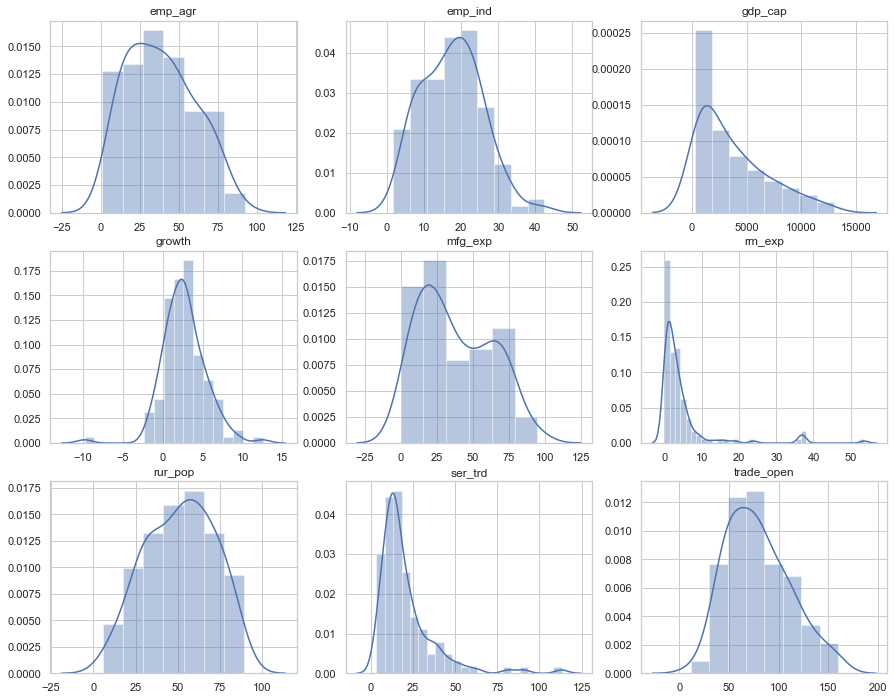

In [8]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (15, 12))

lst = data.columns

for i in range(1, 10):
    plt.subplot(3, 3, i)
    sns.distplot(data[lst[i-1]])
    plt.title(lst[i-1])
    plt.xlabel("")

### Drop growth and gdp

I'm choosing not to include Growth and GDP per capita in the cluster analysis. Insted, I will consider these as labels and add them back after the clustering is done.

In [9]:
labs = data[['gdp_cap', 'growth']]

data = data.drop(['gdp_cap', 'growth'], axis = 'columns')

### Plot correlations between variables

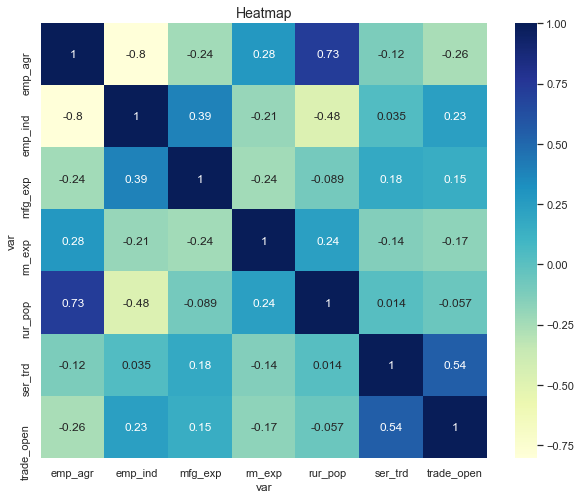

In [10]:
plt.figure(figsize = (10, 8))

sns.heatmap(data.corr(), cmap = 'YlGnBu', annot = True)

plt.title('Heatmap', fontsize = 14)
plt.show()

## Scaling the Data
The clustering analysis requires all variabels to be standardized with mean 0 and variance 1. This is achieced using the scale function in the scikit-learn package.  

In [11]:
data_scaled = preprocessing.scale(data)

data_scaled = pd.DataFrame(data_scaled, 
                           index = data.index, 
                           columns = data.columns)

data_scaled.head()

var,emp_agr,emp_ind,mfg_exp,rm_exp,rur_pop,ser_trd,trade_open
Country Name,,,,,,,
Afghanistan,0.776689,-0.425041,-0.694337,0.316906,1.237718,-0.003371,1.769782
Albania,0.278367,0.170556,0.730545,-0.133218,-0.174698,1.079665,-0.065840
Algeria,-1.219341,1.539617,-1.450258,-0.569742,-0.938054,-0.707056,-0.293068
Angola,0.463395,-1.179746,-1.207108,-0.196666,-0.553240,0.166223,0.897450
Argentina,-1.735533,0.757293,-0.226410,-0.436698,-2.096568,-0.843191,-1.399310


## Initial Principal Component Analysis

As stated earlier, the first step in the analysis is to use PCA to reduce the number of features in the dataset before applying the k-means algorithm and generating the final clusters.   



https://365datascience.com/pca-k-means/

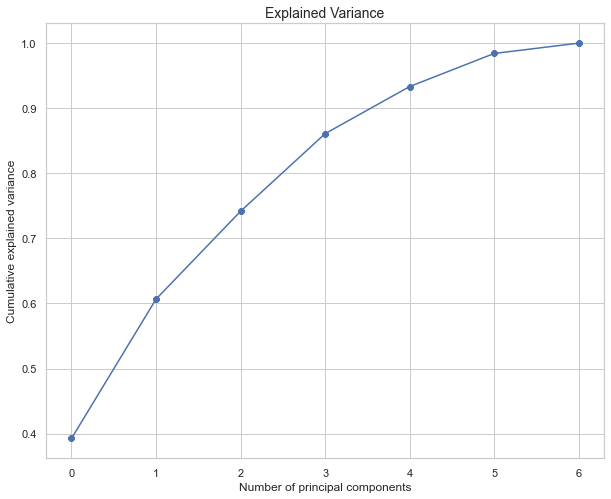

In [12]:
# Fit the data using PCA
pca = PCA()
pca.fit(data_scaled)

# Obtain and plot the resulting explained variance
exp_var = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
plt.plot(range(0, len(exp_var)), 
         exp_var.cumsum(), 
         marker = '8')

plt.title('Explained Variance', fontsize = 14)
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.show()

### Select number of clusters

Following (?), the number of principal components is selected so that roughly 80 \% of the explained variance is preserved. As can be seen in the figure above, this indicates that we should keep three components for this dataset. The selection is done automatically below.

In [13]:
exp_var_sum = exp_var[0]
k = 0
while exp_var_sum < 0.8:
    k +=1
    exp_var_sum +=exp_var[k]
    
print('Number of components: \n', k)

Number of components: 
 3


### Transform data

Based on the result above, the data will now be transformed into three principal components. The transformed data will then be used in the k-means analysis. 

In [14]:
pca = PCA(n_components = k)
pca.fit(data_scaled)

pca_scores = pca.transform(data_scaled)

## Implementing k-means Clustering
### Selecting number of clusters

To select the number of clusters to use in the analysis, the commonly used elbow method is applied. This essentially entails running the algorithm for different numbers of clusters and plotting this against the resulting Within Cluster Sum of Squares, or inertia. Ideally, one would like to see a clear kink in the curve, indicating a number of cluster after which the marginal reduction of sqared error reduction of additional clusters is diminishing.    

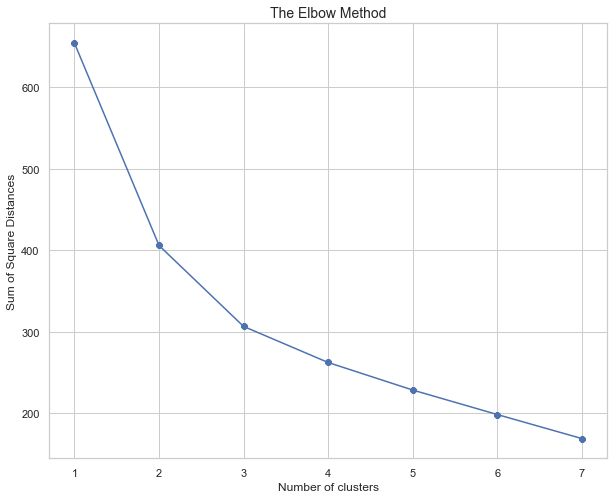

In [15]:
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 8):
    kmeans = KMeans(n_clusters = i, 
                    init = 'k-means++', 
                    random_state = 0)
    kmeans.fit(pca_scores)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 8), wcss, marker = '8')
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Square Distances')
plt.show()

There isn't a really convincing kink in the plot above and it's not obvious wether using two or three clusters would be the best choice. To make the analysis more interesting, however, I will choose to use three clusters for the remainder of the analyiss.  

In [16]:
clusters = 3
# Fitting K-Means to the dataset and generating an array with the resulting clusters
kmeans   = KMeans(n_clusters = clusters, 
                  init = 'k-means++', 
                  random_state = 0)

y_kmeans = kmeans.fit_predict(pca_scores)

# Changing the clusters from (0,1,2) to (1,2,3)
y_kmeans += 1

# Converting the cluster array to a data frame and adding it to the original data
cluster         = pd.DataFrame(y_kmeans)
cluster.index   = data.index
data['cluster'] = cluster

# Adding growth and GDP per capita back to the data
data = pd.concat([labs, data], axis = 'columns')

# Get count of number of countries in each cluster
data['count'] = data.groupby('cluster')['cluster'].transform('count')

# Calculate the mean of each variable for each cluster
kmeans_mean_cluster = pd.DataFrame(round(data.groupby('cluster').mean(),1))

kmeans_mean_cluster

var,gdp_cap,growth,emp_agr,emp_ind,mfg_exp,rm_exp,rur_pop,ser_trd,trade_open,count
cluster,,,,,,,,,,
1,1336.5,2.7,60.8,9.8,23.6,9.3,67.5,14.7,65.9,44
2,3893.8,2.5,31.3,19.6,46.5,2.3,51.0,39.7,113.8,33
3,5662.4,2.8,23.1,23.0,45.2,2.2,37.1,12.9,68.5,49


## Results

The table above show the means of the variables for each identified cluster. Note that GDP per capita (```gdp_cap```) and growth were added after the clustering and thus in some sense can be seen as "labels".  

Cluster 1 stands out the most in that the average share of exports consisting of raw materials (```rm_exp```) is significantly higher than for the other clusters. Not suprisingly, this cluster appears to have a larger agricultural and a smaller industrial sector than the other clusters. These countries are on average also by far the poorest of the countries studied.

Cluster 2 appears to in many ways be similar to cluster 3. The primary differences are the size of trade in services as a fraction of GDP (```ser_trd```) and trade openess (```trade_open```). It also has a slightly larger agricultural and a slighyly smaller industrial sector than cluster 3. The countries in cluster 2 are also on average somewhat poorer than those in cluster 3. 

Interestingly there are no significant differences in average growth rates between the clusters. It is also interesting to note that the poorest and richest countries (clusters 1 and 3) on average are quite similar in terms of trade in services and trade openess.

## Visualize the Results

To visualize the results I will plot the resulting clusters both with respect to the first two components, and later also with respect to all components. To do this, a new dataframe with the PCA scores and corresponding clusters is first generated.

In [17]:
scores_df = pd.DataFrame(pca_scores, index= data.index)

data_full = pd.concat([data['cluster'], scores_df], axis = 1)

data_full['cluster'] = data_full['cluster'].astype(str)

data_full.rename(columns = {i : 'PC_' + str(i+1) for i in range(0,3)}, inplace = True)

data_full.head()

,cluster,PC_1,PC_2,PC_3
Country Name,,,,
Afghanistan,1,0.975972,1.534389,-0.690480
Albania,2,-0.431829,0.774969,0.426011
Algeria,3,-1.377497,-1.662891,-1.077345
Angola,1,0.631560,0.566792,-1.194643
Argentina,3,-1.749009,-2.571921,-0.322549


### Two component plot

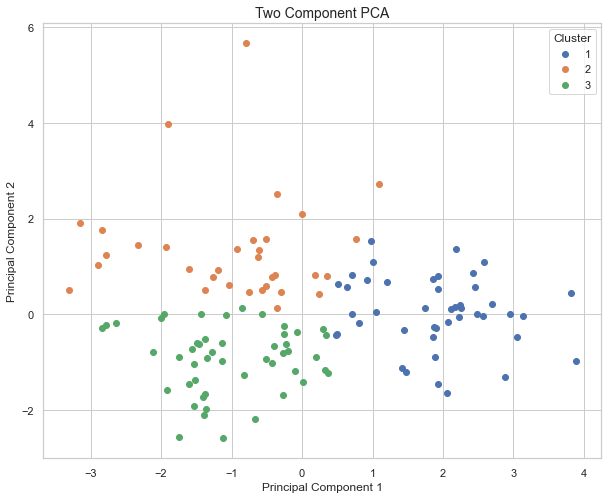

In [18]:
plt.figure(figsize=(10, 8))

for i in range(1,4):
    x = data_full['PC_1'][data_full['cluster'] == str(i)]
    y = data_full['PC_2'][data_full['cluster'] == str(i)]
    plt.scatter(x, y, label = str(i))
    
plt.legend(title = 'Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Two Component PCA', fontsize = 14)

plt.show()

Based on the figure above, it appears the principal component analysis and k-means clustering has indeed managed to separate the data into three farily distinct clusters. 